# Cross-Dataset Deepfake Speech Detection

이 노트북은 ASVspoof2019 LA (train)으로 학습하고, 다양한 데이터셋에서 cross-dataset 평가를 수행합니다.

## 실험 목표
1. **학습 데이터**: ASVspoof2019 LA (train)
2. **검증 데이터**: ASVspoof2019 LA (eval), ASVspoof2021 DF, WaveFake
3. **모델 비교**:
   - Speaker-Invariant Detector (제안 방법)
   - WavLM Frozen Baseline
   - RawNet2 Frozen (Pre-trained)
   - AASIST Frozen (Pre-trained)

## 1. Setup & Configuration

In [13]:
# 1.1 Imports
import os
import sys
import torch
import numpy as np
import pandas as pd
import librosa
import pickle
from pathlib import Path
from typing import List, Tuple, Dict, Optional

# ML Libraries
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve
)
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# Deep Learning
from transformers import WavLMModel, Wav2Vec2FeatureExtractor
import torch.nn.functional as F

# Config parsing
import yaml
import json

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm.auto import tqdm

# Warnings
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.7.1+cu118
CUDA available: True


In [14]:
# 1.2 Device Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.2 GB


In [15]:
# 1.3 Path Configuration
class Config:
    # ASVspoof2019 LA
    LA_ROOT = Path("/mnt/ddn/kyudan/Deepfake-speech/LA")
    LA_TRAIN_AUDIO = LA_ROOT / "ASVspoof2019_LA_train" / "flac"
    LA_DEV_AUDIO = LA_ROOT / "ASVspoof2019_LA_dev" / "flac"
    LA_EVAL_AUDIO = LA_ROOT / "ASVspoof2019_LA_eval" / "flac"
    LA_PROTOCOLS = LA_ROOT / "ASVspoof2019_LA_cm_protocols"
    
    # ASVspoof2021 DF (다운로드 필요)
    DF_ROOT = Path("/mnt/tmp/Deepfake-speech/data/ASVspoof2021_DF")
    
    # WaveFake (다운로드 필요)
    WAVEFAKE_ROOT = Path("/mnt/tmp/Deepfake-speech/data/WaveFake")
    
    # Models
    MODELS_DIR = Path("/mnt/tmp/Deepfake-speech/models")
    RAWNET2_DIR = MODELS_DIR / "rawnet2-antispoofing"  # 경로 수정
    AASIST_DIR = MODELS_DIR / "aasist"
    TRAINED_DIR = MODELS_DIR / "trained"
    
    # Results
    RESULTS_DIR = Path("/mnt/tmp/Deepfake-speech/results")
    
    # Feature cache
    CACHE_DIR = Path("/mnt/tmp/Deepfake-speech/cache")

# Create directories
Config.TRAINED_DIR.mkdir(parents=True, exist_ok=True)
Config.RESULTS_DIR.mkdir(parents=True, exist_ok=True)
Config.CACHE_DIR.mkdir(parents=True, exist_ok=True)

print("Path configuration complete.")
print(f"LA_ROOT exists: {Config.LA_ROOT.exists()}")
print(f"RAWNET2_DIR exists: {Config.RAWNET2_DIR.exists()}")
print(f"AASIST_DIR exists: {Config.AASIST_DIR.exists()}")

Path configuration complete.
LA_ROOT exists: True
RAWNET2_DIR exists: True
AASIST_DIR exists: True


## 2. Data Loaders

In [16]:
# 2.1 ASVspoof2019 LA DataLoader

def load_asvspoof_protocol(protocol_path: str) -> pd.DataFrame:
    """
    ASVspoof2019 protocol 파일을 로드합니다.
    
    Protocol format: SPEAKER_ID FILE_ID - ATTACK_TYPE LABEL
    """
    data = []
    
    with open(protocol_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                speaker_id = parts[0]
                file_id = parts[1]
                attack_type = parts[3]
                label = parts[4]
                
                data.append({
                    'speaker_id': speaker_id,
                    'file_id': file_id,
                    'attack_type': attack_type,
                    'label': label
                })
    
    df = pd.DataFrame(data)
    return df


def build_asvspoof_dataframe(
    protocol_path: str,
    audio_dir: str,
    audio_extension: str = '.flac'
) -> pd.DataFrame:
    """
    ASVspoof2019 데이터셋 DataFrame을 생성합니다.
    """
    # Protocol 로드
    df = load_asvspoof_protocol(protocol_path)
    
    # Binary label 생성 (0: bonafide/real, 1: spoof/fake)
    df['binary_label'] = df['label'].apply(lambda x: 0 if x == 'bonafide' else 1)
    
    # Audio path 생성
    audio_dir = Path(audio_dir)
    df['audio_path'] = df['file_id'].apply(lambda x: str(audio_dir / f"{x}{audio_extension}"))
    
    # 파일 존재 여부 확인
    df['exists'] = df['audio_path'].apply(lambda x: Path(x).exists())
    
    missing_count = (~df['exists']).sum()
    if missing_count > 0:
        print(f"Warning: {missing_count} audio files not found")
    
    # 존재하는 파일만 유지
    df = df[df['exists']].copy()
    df = df.drop(columns=['exists'])
    
    return df


def get_asvspoof19_datasets() -> Dict[str, pd.DataFrame]:
    """
    ASVspoof2019 LA train/dev/eval 데이터셋 로드
    """
    datasets = {}
    
    # Train
    print("Loading ASVspoof2019 LA train...")
    datasets['train'] = build_asvspoof_dataframe(
        protocol_path=str(Config.LA_PROTOCOLS / "ASVspoof2019.LA.cm.train.trn.txt"),
        audio_dir=str(Config.LA_TRAIN_AUDIO)
    )
    
    # Dev
    print("Loading ASVspoof2019 LA dev...")
    datasets['dev'] = build_asvspoof_dataframe(
        protocol_path=str(Config.LA_PROTOCOLS / "ASVspoof2019.LA.cm.dev.trl.txt"),
        audio_dir=str(Config.LA_DEV_AUDIO)
    )
    
    # Eval
    print("Loading ASVspoof2019 LA eval...")
    datasets['eval'] = build_asvspoof_dataframe(
        protocol_path=str(Config.LA_PROTOCOLS / "ASVspoof2019.LA.cm.eval.trl.txt"),
        audio_dir=str(Config.LA_EVAL_AUDIO)
    )
    
    return datasets

In [17]:
# ASVspoof2019 LA 데이터 로드
asvspoof19_data = get_asvspoof19_datasets()

print("\n" + "="*80)
print("ASVspoof2019 LA Dataset Summary")
print("="*80)

for split, df in asvspoof19_data.items():
    print(f"\n[{split.upper()}]")
    print(f"  Total samples: {len(df)}")
    print(f"  Bonafide: {(df['binary_label'] == 0).sum()}")
    print(f"  Spoof: {(df['binary_label'] == 1).sum()}")
    print(f"  Speakers: {df['speaker_id'].nunique()}")
    if split != 'train':
        print(f"  Attack types: {df['attack_type'].unique()}")

Loading ASVspoof2019 LA train...
Loading ASVspoof2019 LA dev...
Loading ASVspoof2019 LA eval...

ASVspoof2019 LA Dataset Summary

[TRAIN]
  Total samples: 25380
  Bonafide: 2580
  Spoof: 22800
  Speakers: 20

[DEV]
  Total samples: 24844
  Bonafide: 2548
  Spoof: 22296
  Speakers: 20
  Attack types: ['-' 'A01' 'A02' 'A03' 'A04' 'A05' 'A06']

[EVAL]
  Total samples: 71237
  Bonafide: 7355
  Spoof: 63882
  Speakers: 67
  Attack types: ['A11' 'A14' 'A16' 'A09' 'A13' '-' 'A12' 'A18' 'A15' 'A08' 'A17' 'A10'
 'A07' 'A19']


In [18]:
# 2.2 데이터셋 다운로드 유틸리티

import subprocess
import zipfile
import tarfile

def download_asvspoof21_df(target_dir: Path = None):
    """
    ASVspoof2021 DF 데이터셋 다운로드

    Source: https://zenodo.org/records/4835108
    Size: ~34.5GB (4 tar.gz files) + evaluation keys
    """
    target_dir = target_dir or Config.DF_ROOT
    target_dir.mkdir(parents=True, exist_ok=True)

    print("="*60)
    print("ASVspoof2021 DF Dataset Download")
    print("="*60)
    print(f"Target directory: {target_dir}")
    print(f"Total size: ~34.5GB (audio) + keys")
    print()

    # Zenodo download URLs (audio files)
    base_url = "https://zenodo.org/records/4835108/files"
    audio_files = [
        "ASVspoof2021_DF_eval_part00.tar.gz",
        "ASVspoof2021_DF_eval_part01.tar.gz",
        "ASVspoof2021_DF_eval_part02.tar.gz",
        "ASVspoof2021_DF_eval_part03.tar.gz",
    ]

    # Download audio files
    for filename in audio_files:
        output_path = target_dir / filename
        if output_path.exists():
            print(f"[SKIP] {filename} already exists")
            continue

        url = f"{base_url}/{filename}"
        print(f"[DOWNLOAD] {filename}...")

        try:
            subprocess.run(
                ["wget", "-c", "-O", str(output_path), url],
                check=True
            )
            print(f"[OK] {filename}")
        except subprocess.CalledProcessError as e:
            print(f"[ERROR] Failed to download {filename}: {e}")
            return False

    # Download evaluation keys from asvspoof.org
    keys_url = "https://www.asvspoof.org/asvspoof2021/DF-keys-full.tar.gz"
    keys_filename = "DF-keys-full.tar.gz"
    keys_path = target_dir / keys_filename

    if not keys_path.exists():
        print(f"\n[DOWNLOAD] Evaluation keys: {keys_filename}...")
        try:
            subprocess.run(
                ["wget", "-c", "-O", str(keys_path), keys_url],
                check=True
            )
            print(f"[OK] {keys_filename}")
        except subprocess.CalledProcessError as e:
            print(f"[ERROR] Failed to download evaluation keys: {e}")
            print("Manual download: https://www.asvspoof.org/index2021.html")
    else:
        print(f"[SKIP] {keys_filename} already exists")

    # Extract audio files
    print("\n[EXTRACT] Extracting audio tar.gz files...")
    for filename in audio_files:
        tar_path = target_dir / filename
        if tar_path.exists():
            # Check if already extracted
            extracted_marker = target_dir / f".{filename}.extracted"
            if extracted_marker.exists():
                print(f"[SKIP] {filename} already extracted")
                continue
            try:
                with tarfile.open(tar_path, 'r:gz') as tar:
                    tar.extractall(path=target_dir)
                extracted_marker.touch()
                print(f"[OK] Extracted {filename}")
            except Exception as e:
                print(f"[ERROR] Failed to extract {filename}: {e}")

    # Extract evaluation keys
    print("\n[EXTRACT] Extracting evaluation keys...")
    if keys_path.exists():
        keys_extracted_marker = target_dir / f".{keys_filename}.extracted"
        if not keys_extracted_marker.exists():
            try:
                with tarfile.open(keys_path, 'r:gz') as tar:
                    tar.extractall(path=target_dir)
                keys_extracted_marker.touch()
                print(f"[OK] Extracted {keys_filename}")
            except Exception as e:
                print(f"[ERROR] Failed to extract {keys_filename}: {e}")
        else:
            print(f"[SKIP] {keys_filename} already extracted")

    print("\n[DONE] ASVspoof2021 DF download complete!")
    return True


def download_wavefake(target_dir: Path = None):
    """
    WaveFake 데이터셋 다운로드

    Source: https://zenodo.org/record/5642694
    Size: ~25GB
    Contains: 104,885 generated audio clips
    """
    target_dir = target_dir or Config.WAVEFAKE_ROOT
    target_dir.mkdir(parents=True, exist_ok=True)

    print("="*60)
    print("WaveFake Dataset Download")
    print("="*60)
    print(f"Target directory: {target_dir}")
    print(f"Total size: ~25GB")
    print()

    # Zenodo download URLs
    base_url = "https://zenodo.org/record/5642694/files"
    files = [
        "generated_audio.zip",  # Main audio files
        "real_audio.zip",       # Real audio for comparison (optional)
    ]

    for filename in files:
        output_path = target_dir / filename
        if output_path.exists():
            print(f"[SKIP] {filename} already exists")
            continue

        url = f"{base_url}/{filename}"
        print(f"[DOWNLOAD] {filename}...")

        try:
            subprocess.run(
                ["wget", "-c", "-O", str(output_path), url],
                check=True
            )
            print(f"[OK] {filename}")
        except subprocess.CalledProcessError as e:
            print(f"[ERROR] Failed to download {filename}: {e}")
            return False

    # Extract files
    print("\n[EXTRACT] Extracting zip files...")
    for filename in files:
        zip_path = target_dir / filename
        if zip_path.exists() and filename.endswith('.zip'):
            extracted_marker = target_dir / f".{filename}.extracted"
            if extracted_marker.exists():
                print(f"[SKIP] {filename} already extracted")
                continue
            try:
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(target_dir)
                extracted_marker.touch()
                print(f"[OK] Extracted {filename}")
            except Exception as e:
                print(f"[ERROR] Failed to extract {filename}: {e}")

    print("\n[DONE] WaveFake download complete!")
    return True


def download_all_datasets():
    """모든 추가 데이터셋 다운로드"""
    print("Downloading all additional datasets...")
    print("This may take several hours depending on your connection.\n")

    success = True

    if not Config.DF_ROOT.exists() or not any(Config.DF_ROOT.iterdir()):
        success &= download_asvspoof21_df()
    else:
        print(f"ASVspoof2021 DF already exists at {Config.DF_ROOT}")

    if not Config.WAVEFAKE_ROOT.exists() or not any(Config.WAVEFAKE_ROOT.iterdir()):
        success &= download_wavefake()
    else:
        print(f"WaveFake already exists at {Config.WAVEFAKE_ROOT}")

    return success


# 2.3 ASVspoof2021 DF DataLoader

def get_asvspoof21_df_data() -> Optional[pd.DataFrame]:
    """
    ASVspoof2021 DF 데이터셋 로드
    다운로드 필요: https://zenodo.org/records/4835108

    ASVspoof2021 DF 구조:
    - Evaluation set only (no train/dev)
    - Protocol: keys/DF/CM/trial_metadata.txt
    - Format: FILE_ID - - CODEC LABEL (bonafide/spoof)
    """
    if not Config.DF_ROOT.exists():
        print(f"Warning: ASVspoof2021 DF not found at {Config.DF_ROOT}")
        print("Run download_asvspoof21_df() to download the dataset")
        print("Or download manually from: https://zenodo.org/records/4835108")
        return None

    # Find protocol file (expanded search paths)
    protocol_candidates = [
        Config.DF_ROOT / "keys" / "DF" / "CM" / "trial_metadata.txt",
        Config.DF_ROOT / "DF" / "keys" / "CM" / "trial_metadata.txt",
        Config.DF_ROOT / "keys" / "CM" / "trial_metadata.txt",
        Config.DF_ROOT / "LA" / "keys" / "CM" / "trial_metadata.txt",
        Config.DF_ROOT / "ASVspoof2021_DF_eval" / "trial_metadata.txt",
        Config.DF_ROOT / "trial_metadata.txt",
    ]

    protocol_path = None
    for p in protocol_candidates:
        if p.exists():
            protocol_path = p
            break

    if protocol_path is None:
        print("Warning: ASVspoof2021 DF protocol file not found")
        print("Expected locations:", [str(p) for p in protocol_candidates])
        print("\nPlease run download_asvspoof21_df() to download evaluation keys")
        return None

    # Find audio directory
    audio_candidates = [
        Config.DF_ROOT / "ASVspoof2021_DF_eval" / "flac",
        Config.DF_ROOT / "flac",
    ]

    audio_dir = None
    for d in audio_candidates:
        if d.exists():
            audio_dir = d
            break

    if audio_dir is None:
        print("Warning: ASVspoof2021 DF audio directory not found")
        return None

    # Load protocol
    print(f"Loading ASVspoof2021 DF from {protocol_path}...")
    data = []
    with open(protocol_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                file_id = parts[0]
                # ASVspoof2021 format: FILE_ID - - CODEC LABEL
                label = parts[4] if len(parts) > 4 else parts[-1]

                data.append({
                    'file_id': file_id,
                    'label': label,
                    'binary_label': 0 if label == 'bonafide' else 1,
                    'audio_path': str(audio_dir / f"{file_id}.flac")
                })

    df = pd.DataFrame(data)

    # Check file existence
    df['exists'] = df['audio_path'].apply(lambda x: Path(x).exists())
    missing = (~df['exists']).sum()
    if missing > 0:
        print(f"Warning: {missing} audio files not found")
    df = df[df['exists']].drop(columns=['exists'])

    print(f"Loaded {len(df)} samples (Bonafide: {(df['binary_label']==0).sum()}, Spoof: {(df['binary_label']==1).sum()})")
    return df


# 2.4 WaveFake DataLoader

def get_wavefake_data() -> Optional[pd.DataFrame]:
    """
    WaveFake 데이터셋 로드
    다운로드 필요: https://zenodo.org/record/5642694

    WaveFake 구조:
    - 104,885 generated audio clips (16-bit PCM wav)
    - LJSpeech + JSUT 기반
    - 6가지 vocoder: MelGAN, Parallel WaveGAN, Multi-Band MelGAN, Full-Band MelGAN, HiFi-GAN, WaveGlow

    디렉토리 구조:
    - generated_audio/
      - ljspeech_melgan/
      - ljspeech_parallel_wavegan/
      - ljspeech_multi_band_melgan/
      - ljspeech_full_band_melgan/
      - ljspeech_hifigan/
      - ljspeech_waveglow/
      - jsut_*/
    - real_audio/ (optional)
    """
    if not Config.WAVEFAKE_ROOT.exists():
        print(f"Warning: WaveFake not found at {Config.WAVEFAKE_ROOT}")
        print("Run download_wavefake() to download the dataset")
        print("Or download manually from: https://zenodo.org/record/5642694")
        return None

    # Find audio directories
    generated_dir = Config.WAVEFAKE_ROOT / "generated_audio"
    real_dir = Config.WAVEFAKE_ROOT / "real_audio"

    if not generated_dir.exists():
        # Try alternative structure
        generated_dir = Config.WAVEFAKE_ROOT

    data = []

    # Load fake audio (from all vocoder directories)
    vocoder_dirs = [
        "ljspeech_melgan",
        "ljspeech_parallel_wavegan",
        "ljspeech_multi_band_melgan",
        "ljspeech_full_band_melgan",
        "ljspeech_hifigan",
        "ljspeech_waveglow",
    ]

    print(f"Loading WaveFake from {Config.WAVEFAKE_ROOT}...")

    for vocoder in vocoder_dirs:
        vocoder_path = generated_dir / vocoder
        if vocoder_path.exists():
            wav_files = list(vocoder_path.glob("*.wav"))
            for wav_file in wav_files:
                data.append({
                    'file_id': wav_file.stem,
                    'vocoder': vocoder,
                    'label': 'spoof',
                    'binary_label': 1,  # Fake
                    'audio_path': str(wav_file)
                })
            print(f"  {vocoder}: {len(wav_files)} files")

    # Load real audio (LJSpeech)
    if real_dir.exists():
        ljspeech_dir = real_dir / "ljspeech"
        if ljspeech_dir.exists():
            wav_files = list(ljspeech_dir.glob("*.wav"))
            for wav_file in wav_files:
                data.append({
                    'file_id': wav_file.stem,
                    'vocoder': 'real',
                    'label': 'bonafide',
                    'binary_label': 0,  # Real
                    'audio_path': str(wav_file)
                })
            print(f"  real (ljspeech): {len(wav_files)} files")

    if len(data) == 0:
        print("Warning: No audio files found in WaveFake directory")
        return None

    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} samples (Real: {(df['binary_label']==0).sum()}, Fake: {(df['binary_label']==1).sum()})")
    return df

In [19]:
# # 2.2 ASVspoof2021 DF DataLoader (Placeholder)

# def get_asvspoof21_df_data() -> Optional[pd.DataFrame]:
#     """
#     ASVspoof2021 DF 데이터셋 로드
#     다운로드 필요: https://zenodo.org/records/4835108
#     """
#     if not Config.DF_ROOT.exists():
#         print(f"Warning: ASVspoof2021 DF not found at {Config.DF_ROOT}")
#         print("Download from: https://zenodo.org/records/4835108")
#         return None
    
#     # TODO: Implement when dataset is available
#     # Protocol format may differ from ASVspoof2019
#     raise NotImplementedError("ASVspoof2021 DF loader not implemented")


# # 2.3 WaveFake DataLoader (Placeholder)

# def get_wavefake_data() -> Optional[pd.DataFrame]:
#     """
#     WaveFake 데이터셋 로드
#     다운로드 필요: https://zenodo.org/record/5642694
    
#     WaveFake 구조:
#     - 104,885 generated audio clips (16-bit PCM wav)
#     - LJSpeech + JSUT 기반
#     - 6가지 vocoder: MelGAN, Parallel WaveGAN, Multi-Band MelGAN, Full-Band MelGAN, HiFi-GAN, WaveGlow
#     """
#     if not Config.WAVEFAKE_ROOT.exists():
#         print(f"Warning: WaveFake not found at {Config.WAVEFAKE_ROOT}")
#         print("Download from: https://zenodo.org/record/5642694")
#         return None
    
#     # TODO: Implement when dataset is available
#     raise NotImplementedError("WaveFake loader not implemented")

In [20]:
# # 2.5 [선택사항] 추가 데이터셋 다운로드
# # 아래 셀의 주석을 해제하고 실행하면 ASVspoof2021 DF와 WaveFake를 다운로드합니다.
# # 전체 약 60GB이며, 네트워크 상황에 따라 몇 시간이 걸릴 수 있습니다.

# # === 개별 다운로드 (필요한 것만 선택) ===
# download_asvspoof21_df()  # ASVspoof2021 DF (~34.5GB + evaluation keys)
# download_wavefake()       # WaveFake (~25GB)

# # === 또는 전체 다운로드 ===
# # download_all_datasets()

# print("데이터셋 상태:")
# print(f"  ASVspoof2021 DF: {'존재' if Config.DF_ROOT.exists() else '다운로드 필요'}")
# print(f"  WaveFake: {'존재' if Config.WAVEFAKE_ROOT.exists() else '다운로드 필요'}")
# print()
# print("다운로드하려면 위 함수 호출의 주석을 해제하고 실행하세요.")
# print("  - download_asvspoof21_df(): ASVspoof2021 DF 데이터셋 + 평가 키")
# print("  - download_wavefake(): WaveFake 데이터셋")

## 3. Model Definitions

In [21]:
# 3.1 WavLM Feature Extractor (공통)

class WavLMFeatureExtractor:
    """
    WavLM-Large 모델을 사용한 Feature Extractor
    모든 모델에서 공통으로 사용
    """
    def __init__(self, model_name: str = "microsoft/wavlm-large", device: str = None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        
        print(f"Loading WavLM model: {model_name}...")
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
        self.model = WavLMModel.from_pretrained(model_name).to(self.device)
        self.model.eval()
        
        # Freeze all parameters
        for param in self.model.parameters():
            param.requires_grad = False
        
        print(f"WavLM loaded on {self.device}")
    
    def extract(self, audio_path: str) -> Optional[np.ndarray]:
        """
        오디오 파일에서 WavLM feature 추출
        
        Returns:
            np.ndarray: (1024,) shaped feature vector (mean pooled)
        """
        try:
            # Load audio
            audio, _ = librosa.load(audio_path, sr=16000, mono=True)
            
            # Prepare input
            inputs = self.feature_extractor(
                audio, sampling_rate=16000, return_tensors="pt", padding=True
            )
            input_values = inputs.input_values.to(self.device)
            
            # Extract features
            with torch.no_grad():
                outputs = self.model(input_values)
            
            # Mean pooling over time dimension
            features = outputs.last_hidden_state.mean(dim=1).squeeze(0).cpu().numpy()
            
            return features
            
        except Exception as e:
            print(f"Feature extraction error for {audio_path}: {e}")
            return None
    
    def extract_batch(
        self, 
        audio_paths: List[str], 
        cache_path: Optional[str] = None,
        desc: str = "Extracting features"
    ) -> np.ndarray:
        """
        배치 feature 추출 (캐싱 지원)
        """
        # Check cache
        if cache_path and Path(cache_path).exists():
            print(f"Loading cached features from {cache_path}")
            with open(cache_path, 'rb') as f:
                return pickle.load(f)
        
        # Extract features
        features = []
        for path in tqdm(audio_paths, desc=desc):
            feat = self.extract(path)
            if feat is not None:
                features.append(feat)
            else:
                # Use zero vector for failed extractions
                features.append(np.zeros(1024))
        
        features = np.array(features)
        
        # Save cache
        if cache_path:
            Path(cache_path).parent.mkdir(parents=True, exist_ok=True)
            with open(cache_path, 'wb') as f:
                pickle.dump(features, f)
            print(f"Features cached to {cache_path}")
        
        return features

In [22]:
# 3.2 WavLM Frozen Baseline

class WavLMFrozenBaseline:
    """
    WavLM (Frozen) + Logistic Regression Baseline
    
    WavLM-Large feature를 추출하고 Logistic Regression으로 분류
    """
    def __init__(self, wavlm_extractor: WavLMFeatureExtractor = None, device: str = None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        
        # WavLM Feature Extractor
        if wavlm_extractor is None:
            self.wavlm = WavLMFeatureExtractor(device=self.device)
        else:
            self.wavlm = wavlm_extractor
        
        # Classifier
        self.scaler = StandardScaler()
        self.classifier = LogisticRegression(random_state=42, max_iter=1000)
        self.is_fitted = False
    
    def fit(
        self, 
        audio_paths: List[str], 
        labels: List[int],
        cache_path: Optional[str] = None
    ) -> float:
        """
        모델 학습
        
        Returns:
            Train accuracy
        """
        print("Extracting features for training...")
        X = self.wavlm.extract_batch(audio_paths, cache_path=cache_path)
        y = np.array(labels)
        
        print("Scaling features...")
        X_scaled = self.scaler.fit_transform(X)
        
        print("Training Logistic Regression...")
        self.classifier.fit(X_scaled, y)
        self.is_fitted = True
        
        train_acc = self.classifier.score(X_scaled, y)
        print(f"Training complete. Train accuracy: {train_acc:.4f}")
        
        return train_acc
    
    def predict(self, audio_path: str) -> Dict:
        """
        단일 파일 예측
        """
        if not self.is_fitted:
            raise ValueError("Model not fitted. Call fit() first.")
        
        feat = self.wavlm.extract(audio_path)
        if feat is None:
            return None
        
        feat = feat.reshape(1, -1)
        feat_scaled = self.scaler.transform(feat)
        
        pred = self.classifier.predict(feat_scaled)[0]
        prob = self.classifier.predict_proba(feat_scaled)[0]
        
        return {
            'label': pred,
            'probability': prob,
            'score': prob[1]  # Spoof probability
        }
    
    def predict_batch(
        self, 
        audio_paths: List[str],
        cache_path: Optional[str] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        배치 예측
        
        Returns:
            (predictions, scores)
        """
        if not self.is_fitted:
            raise ValueError("Model not fitted. Call fit() first.")
        
        X = self.wavlm.extract_batch(audio_paths, cache_path=cache_path)
        X_scaled = self.scaler.transform(X)
        
        predictions = self.classifier.predict(X_scaled)
        probabilities = self.classifier.predict_proba(X_scaled)
        scores = probabilities[:, 1]  # Spoof probability
        
        return predictions, scores
    
    def save(self, path: str):
        """모델 저장"""
        save_data = {
            'scaler': self.scaler,
            'classifier': self.classifier,
            'is_fitted': self.is_fitted
        }
        with open(path, 'wb') as f:
            pickle.dump(save_data, f)
        print(f"Model saved to {path}")
    
    def load(self, path: str):
        """모델 로드"""
        with open(path, 'rb') as f:
            save_data = pickle.load(f)
        self.scaler = save_data['scaler']
        self.classifier = save_data['classifier']
        self.is_fitted = save_data['is_fitted']
        print(f"Model loaded from {path}")

In [23]:
# 3.3 Speaker-Invariant Detector (Our Method)

class SpeakerInvariantDetector:
    """
    Speaker-Invariant Deepfake Detector
    
    핵심 아이디어:
    1. WavLM-Large feature 추출
    2. 화자별 centroid 계산
    3. PCA로 speaker subspace 추출
    4. Orthogonal projection으로 화자 정보 제거: P_perp = I - U @ U.T
    5. Logistic Regression 분류
    """
    def __init__(
        self, 
        n_speaker_components: int = 10,
        wavlm_extractor: WavLMFeatureExtractor = None,
        device: str = None
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.n_speaker_components = n_speaker_components
        
        # WavLM Feature Extractor
        if wavlm_extractor is None:
            self.wavlm = WavLMFeatureExtractor(device=self.device)
        else:
            self.wavlm = wavlm_extractor
        
        # Speaker subspace components
        self.pca = None
        self.projection_matrix = None
        
        # Classifier
        self.scaler = StandardScaler()
        self.classifier = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
        self.is_fitted = False
    
    def fit(
        self,
        audio_paths: List[str],
        labels: List[int],
        speaker_ids: List[str],
        cache_path: Optional[str] = None
    ) -> float:
        """
        모델 학습
        
        1. Feature extraction
        2. Scaling
        3. Speaker subspace computation (PCA on speaker centroids)
        4. Orthogonal projection matrix creation
        5. Classifier training
        """
        print(f"Training Speaker-Invariant Detector (n_components={self.n_speaker_components})...")
        
        # 1. Feature extraction
        print("Extracting features...")
        X_raw = self.wavlm.extract_batch(audio_paths, cache_path=cache_path)
        y = np.array(labels)
        
        # 2. Scaling
        print("Scaling features...")
        X_scaled = self.scaler.fit_transform(X_raw)
        
        # 3. Compute speaker centroids
        print(f"Computing speaker subspace (removing top {self.n_speaker_components} components)...")
        
        # Group by speaker
        spk_map = {}
        for idx, spk in enumerate(speaker_ids):
            if spk not in spk_map:
                spk_map[spk] = []
            spk_map[spk].append(idx)
        
        # Calculate speaker centroids
        speaker_centroids = []
        for spk, indices in spk_map.items():
            centroid = np.mean(X_scaled[indices], axis=0)
            speaker_centroids.append(centroid)
        speaker_centroids = np.array(speaker_centroids)
        
        print(f"  Number of speakers: {len(speaker_centroids)}")
        
        # 4. PCA on speaker centroids
        n_components = min(self.n_speaker_components, len(speaker_centroids) - 1)
        self.pca = PCA(n_components=n_components)
        self.pca.fit(speaker_centroids)
        
        # 5. Create orthogonal projection matrix: P_perp = I - U @ U.T
        U = self.pca.components_.T  # (D, n_components)
        I = np.eye(U.shape[0])
        self.projection_matrix = I - (U @ U.T)
        
        # 6. Project features (remove speaker info)
        X_projected = X_scaled @ self.projection_matrix
        
        # 7. Train classifier
        print("Training classifier...")
        self.classifier.fit(X_projected, y)
        self.is_fitted = True
        
        train_acc = self.classifier.score(X_projected, y)
        print(f"Training complete. Train accuracy: {train_acc:.4f}")
        
        return train_acc
    
    def predict(self, audio_path: str) -> Optional[Dict]:
        """
        단일 파일 예측
        """
        if not self.is_fitted:
            raise ValueError("Model not fitted. Call fit() first.")
        
        feat = self.wavlm.extract(audio_path)
        if feat is None:
            return None
        
        feat = feat.reshape(1, -1)
        feat_scaled = self.scaler.transform(feat)
        feat_projected = feat_scaled @ self.projection_matrix
        
        pred = self.classifier.predict(feat_projected)[0]
        prob = self.classifier.predict_proba(feat_projected)[0]
        
        return {
            'label': pred,
            'probability': prob,
            'score': prob[1]  # Spoof probability
        }
    
    def predict_batch(
        self,
        audio_paths: List[str],
        cache_path: Optional[str] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        배치 예측
        """
        if not self.is_fitted:
            raise ValueError("Model not fitted. Call fit() first.")
        
        X = self.wavlm.extract_batch(audio_paths, cache_path=cache_path)
        X_scaled = self.scaler.transform(X)
        X_projected = X_scaled @ self.projection_matrix
        
        predictions = self.classifier.predict(X_projected)
        probabilities = self.classifier.predict_proba(X_projected)
        scores = probabilities[:, 1]  # Spoof probability
        
        return predictions, scores
    
    def save(self, path: str):
        """모델 저장"""
        save_data = {
            'n_speaker_components': self.n_speaker_components,
            'scaler': self.scaler,
            'pca': self.pca,
            'projection_matrix': self.projection_matrix,
            'classifier': self.classifier,
            'is_fitted': self.is_fitted
        }
        with open(path, 'wb') as f:
            pickle.dump(save_data, f)
        print(f"Model saved to {path}")
    
    def load(self, path: str):
        """모델 로드"""
        with open(path, 'rb') as f:
            save_data = pickle.load(f)
        self.n_speaker_components = save_data['n_speaker_components']
        self.scaler = save_data['scaler']
        self.pca = save_data['pca']
        self.projection_matrix = save_data['projection_matrix']
        self.classifier = save_data['classifier']
        self.is_fitted = save_data['is_fitted']
        print(f"Model loaded from {path}")

In [24]:
# # 3.4 RawNet2 Frozen Baseline (Pre-trained)

# class RawNet2FrozenBaseline:
#     """
#     RawNet2 (Frozen) Baseline
    
#     ASVspoof2019 LA로 학습된 pre-trained weights 사용
#     추가 학습 없이 inference만 수행
    
#     Source: https://github.com/eurecom-asp/rawnet2-antispoofing
#     Pre-trained weights: https://www.asvspoof.org/asvspoof2021/pre_trained_DF_RawNet2.zip
    
#     Input: Raw audio (16kHz, 64000 samples = 4 seconds)
#     Output: Binary classification (0: bonafide, 1: spoof)
#     """
#     def __init__(self, model_dir: str = None, device: str = None):
#         self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
#         self.model_dir = Path(model_dir) if model_dir else Config.RAWNET2_DIR
#         self.model = None
#         self.config = None
#         self.is_loaded = False
#         self.nb_samp = 64000  # 4 seconds at 16kHz
        
#         # Check if RawNet2 repo exists
#         if not self.model_dir.exists():
#             print(f"Warning: RawNet2 not found at {self.model_dir}")
#             print("Clone with: git clone https://github.com/eurecom-asp/rawnet2-antispoofing")
#         else:
#             self._load_model()
    
#     def _download_weights(self):
#         """Download pre-trained weights from asvspoof.org"""
#         weights_url = "https://www.asvspoof.org/asvspoof2021/pre_trained_DF_RawNet2.zip"
#         weights_zip = self.model_dir / "pre_trained_DF_RawNet2.zip"
#         weights_dir = self.model_dir / "pre_trained"
        
#         if not weights_zip.exists():
#             print(f"Downloading RawNet2 pre-trained weights...")
#             try:
#                 import subprocess
#                 subprocess.run(
#                     ["wget", "-c", "-O", str(weights_zip), weights_url],
#                     check=True
#                 )
#                 print(f"Downloaded to {weights_zip}")
#             except Exception as e:
#                 print(f"Failed to download weights: {e}")
#                 print(f"Manual download: {weights_url}")
#                 return None
        
#         # Extract if needed
#         weights_pth = self.model_dir / "pre_trained_DF_RawNet2.pth"
#         if not weights_pth.exists():
#             print("Extracting weights...")
#             try:
#                 import zipfile
#                 with zipfile.ZipFile(weights_zip, 'r') as zip_ref:
#                     zip_ref.extractall(self.model_dir)
#                 print("Extraction complete")
#             except Exception as e:
#                 print(f"Failed to extract: {e}")
#                 return None
        
#         return weights_pth
    
#     def _load_config(self):
#         """Load model configuration from YAML"""
#         config_path = self.model_dir / "model_config_RawNet2.yaml"
#         if not config_path.exists():
#             print(f"Config not found: {config_path}")
#             # Use default config
#             return {
#                 'nb_samp': 64000,
#                 'first_conv': 128,
#                 'in_channels': 1,
#                 'filts': [128, [128, 128], [128, 512], [512, 512]],
#                 'nb_fc_node': 1024,
#                 'gru_node': 1024,
#                 'nb_gru_layer': 3,
#                 'nb_classes': 2
#             }
        
#         with open(config_path, 'r') as f:
#             config = yaml.safe_load(f)
#         return config.get('model', config)
    
#     def _load_model(self):
#         """Load RawNet2 model with pre-trained weights"""
#         try:
#             # Add model directory to path
#             model_dir_str = str(self.model_dir)
#             if model_dir_str not in sys.path:
#                 sys.path.insert(0, model_dir_str)
            
#             # Import RawNet model
#             from model import RawNet
            
#             # Load config
#             self.config = self._load_config()
#             self.nb_samp = self.config.get('nb_samp', 64000)
            
#             # Find weights file
#             weights_candidates = [
#                 self.model_dir / "pre_trained_DF_RawNet2.pth",
#                 self.model_dir / "pre_trained" / "pre_trained_DF_RawNet2.pth",
#                 self.model_dir / "models" / "best_model.pth",
#                 self.model_dir / "best_model.pth",
#             ]
            
#             weights_path = None
#             for candidate in weights_candidates:
#                 if candidate.exists():
#                     weights_path = candidate
#                     break
            
#             # Try to download if not found
#             if weights_path is None:
#                 print("Pre-trained weights not found. Attempting download...")
#                 weights_path = self._download_weights()
            
#             if weights_path is None or not weights_path.exists():
#                 print("Warning: Pre-trained weights not available.")
#                 print("Download from: https://www.asvspoof.org/asvspoof2021/pre_trained_DF_RawNet2.zip")
#                 return
            
#             # Initialize model
#             self.model = RawNet(self.config, self.device).to(self.device)
            
#             # Load weights
#             checkpoint = torch.load(weights_path, map_location=self.device)
#             if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
#                 self.model.load_state_dict(checkpoint['model_state_dict'])
#             else:
#                 self.model.load_state_dict(checkpoint)
            
#             self.model.eval()
            
#             # Freeze all parameters
#             for param in self.model.parameters():
#                 param.requires_grad = False
            
#             self.is_loaded = True
#             print(f"RawNet2 loaded from {weights_path}")
#             print(f"  Input samples: {self.nb_samp} ({self.nb_samp/16000:.2f}s @ 16kHz)")
            
#         except Exception as e:
#             print(f"Error loading RawNet2: {e}")
#             import traceback
#             traceback.print_exc()
    
#     def _preprocess_audio(self, audio_path: str) -> Optional[torch.Tensor]:
#         """Preprocess audio: load, resample, pad/crop to nb_samp"""
#         try:
#             audio, _ = librosa.load(audio_path, sr=16000, mono=True)
            
#             # Pad or crop to nb_samp
#             if len(audio) < self.nb_samp:
#                 # Repeat padding
#                 num_repeats = int(self.nb_samp / len(audio)) + 1
#                 audio = np.tile(audio, num_repeats)[:self.nb_samp]
#             else:
#                 audio = audio[:self.nb_samp]
            
#             return torch.FloatTensor(audio)
#         except Exception as e:
#             print(f"Audio preprocessing error for {audio_path}: {e}")
#             return None
    
#     def predict(self, audio_path: str) -> Optional[Dict]:
#         """
#         Single file prediction
        
#         Returns:
#             Dict with 'label' (0=real, 1=fake) and 'score' (fake probability)
#         """
#         if not self.is_loaded:
#             print("RawNet2 model not loaded.")
#             return None
        
#         try:
#             audio_tensor = self._preprocess_audio(audio_path)
#             if audio_tensor is None:
#                 return None
            
#             audio_tensor = audio_tensor.unsqueeze(0).to(self.device)
            
#             with torch.no_grad():
#                 # is_test=True returns softmax probabilities
#                 output = self.model(audio_tensor, is_test=True)
#                 probs = output.squeeze().cpu().numpy()
            
#             # RawNet2 output: [spoof_prob, bonafide_prob]
#             # 노트북 컨벤션: 0=real(bonafide), 1=fake(spoof)
#             spoof_prob = probs[0]  # index 0 = spoof
#             bonafide_prob = probs[1]  # index 1 = bonafide
            
#             binary_label = 1 if spoof_prob > bonafide_prob else 0
            
#             return {
#                 'label': binary_label,
#                 'score': float(spoof_prob),  # Spoof probability as score
#             }
            
#         except Exception as e:
#             print(f"Prediction error for {audio_path}: {e}")
#             return None
    
#     def predict_batch(self, audio_paths: List[str]) -> Tuple[np.ndarray, np.ndarray]:
#         """
#         Batch prediction
        
#         Returns:
#             (predictions, scores) where predictions are binary labels and scores are spoof probabilities
#         """
#         if not self.is_loaded:
#             print("RawNet2 model not loaded. Returning dummy predictions.")
#             return np.zeros(len(audio_paths)), np.zeros(len(audio_paths))
        
#         predictions = []
#         scores = []
        
#         for path in tqdm(audio_paths, desc="RawNet2 prediction"):
#             result = self.predict(path)
#             if result:
#                 predictions.append(result['label'])
#                 scores.append(result['score'])
#             else:
#                 predictions.append(0)
#                 scores.append(0.0)
        
#         return np.array(predictions), np.array(scores)

In [ ]:
import sys
import shutil
import torch
import torch.nn as nn
import yaml
import numpy as np
import librosa
from pathlib import Path
from tqdm.auto import tqdm
import subprocess
import zipfile

class RawNet2FrozenBaseline:
    """
    RawNet2 (Frozen) Baseline
    
    - Source Code: https://github.com/asvspoof-challenge/2021 (LA/Baseline-RawNet2)
    - Pre-trained Weights: ASVspoof 2021 Baseline (Trained on ASVspoof 2019 LA)
    """
    def __init__(self, model_dir: str = None, device: str = None, force_reload: bool = False):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.root_dir = Path(model_dir) if model_dir else Config.MODELS_DIR / "asvspoof2021_baseline"
        self.repo_dir = self.root_dir / "2021"
        self.code_dir = self.repo_dir / "LA" / "Baseline-RawNet2"
        self.nb_samp = 64000  # 4 seconds
        self.model = None
        self.is_loaded = False
        
        # 1. 환경 설정 (Git Clone & Weight Download)
        self._setup_environment(force_reload=force_reload)
        
        # 2. 모델 로드
        self._load_model()
    
    def _setup_environment(self, force_reload: bool):
        """공식 리포지토리 클론 및 웨이트 다운로드"""
        if force_reload and self.root_dir.exists():
            print(f"[RawNet2] Cleaning up existing directory: {self.root_dir}")
            shutil.rmtree(self.root_dir)
            
        self.root_dir.mkdir(parents=True, exist_ok=True)
        
        # 1) Git Clone (asvspoof-challenge/2021)
        if not self.code_dir.exists():
            print(f"[RawNet2] Cloning official repository...")
            try:
                subprocess.run(
                    ["git", "clone", "https://github.com/asvspoof-challenge/2021.git", str(self.repo_dir)],
                    check=True
                )
            except subprocess.CalledProcessError as e:
                print(f"[Error] Git clone failed: {e}")
                return

        # 2) Weights 다운로드 (ASVspoof 2021 Baseline Weights)
        # Note: 이 웨이트는 DF 트랙 베이스라인으로 제공되지만, 실제로는 ASVspoof 2019 LA로 학습된 모델입니다.
        weights_url = "https://www.asvspoof.org/asvspoof2021/pre_trained_DF_RawNet2.zip"
        weights_zip = self.root_dir / "weights.zip"
        self.weights_path = self.root_dir / "pre_trained_DF_RawNet2.pth"
        
        if not self.weights_path.exists():
            print("[RawNet2] Downloading pre-trained weights...")
            try:
                subprocess.run(["wget", "-c", "-O", str(weights_zip), weights_url], check=True)
                with zipfile.ZipFile(weights_zip, 'r') as zip_ref:
                    zip_ref.extractall(self.root_dir)
                weights_zip.unlink() # zip 삭제
                print("[RawNet2] Download complete.")
            except Exception as e:
                print(f"[Error] Weight download failed: {e}")

    def _load_model(self):
        """모델 아키텍처 로드 및 웨이트 주입 (자동 보정 포함)"""
        try:
            # sys.path에 모델 디렉토리 추가
            if str(self.code_dir) not in sys.path:
                sys.path.insert(0, str(self.code_dir))
            
            from model import RawNet
            
            # 1. YAML 설정 파일 로드
            config_path = self.code_dir / "model_config_RawNet2.yaml"
            if config_path.exists():
                with open(config_path, 'r') as f:
                    config = yaml.safe_load(f)
                model_config = config['model']
            else:
                # 기본값 (Fallback)
                model_config = {
                    'nb_samp': 64000, 'first_conv': 128, 'in_channels': 1,
                    'filts': [128, [128, 128], [128, 512], [512, 512]],
                    'blocks': [2, 4], 'nb_fc_node': 1024, 'gru_node': 1024,
                    'nb_gru_layer': 3, 'nb_classes': 2
                }

            # 2. 모델 초기화 및 웨이트 로드 시도
            self.model = RawNet(model_config, self.device).to(self.device)
            
            if not self.weights_path.exists():
                print("[Error] Weights file not found.")
                return

            try:
                # 첫 번째 시도: 설정 파일 그대로 로드
                self.model.load_state_dict(torch.load(self.weights_path, map_location=self.device))
                print(f"[RawNet2] Model loaded successfully with repo config!")
            
            except RuntimeError as e:
                # 3. 실패 시 (Size Mismatch): 웨이트에 맞춰 Config 자동 보정
                if "size mismatch" in str(e):
                    print(f"[RawNet2] Size mismatch detected. Adjusting config to match weights...")
                    
                    # 로그 기반 보정: Pre-trained weights는 usually first_conv=20, filts=[20, ...]을 사용함
                    adjusted_config = model_config.copy()
                    adjusted_config['first_conv'] = 20
                    adjusted_config['filts'] = [20, [20, 20], [20, 128], [128, 128]]
                    
                    # 모델 재생성
                    self.model = RawNet(adjusted_config, self.device).to(self.device)
                    self.model.load_state_dict(torch.load(self.weights_path, map_location=self.device))
                    print(f"[RawNet2] Model re-loaded successfully with ADJUSTED config (filters=20)!")
                else:
                    raise e

            self.model.eval()
            for param in self.model.parameters():
                param.requires_grad = False
            self.is_loaded = True
            
        except Exception as e:
            print(f"[Error] Loading RawNet2 model: {e}")
            import traceback
            traceback.print_exc()

    def predict(self, audio_path: str):
        if not self.is_loaded: return None
        try:
            # 전처리
            audio, _ = librosa.load(audio_path, sr=16000, mono=True)
            if len(audio) < self.nb_samp:
                num_repeats = int(self.nb_samp / len(audio)) + 1
                audio = np.tile(audio, num_repeats)[:self.nb_samp]
            else:
                audio = audio[:self.nb_samp]
            
            # audio_tensor = torch.FloatTensor(audio).unsqueeze(0).unsqueeze(0).to(self.device)
            audio_tensor = torch.FloatTensor(audio).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                output = self.model(audio_tensor)
                probs = torch.softmax(output, dim=1).squeeze().cpu().numpy()
            
            # Output: [Spoof, Bonafide]
            spoof_prob = probs[0]
            
            return {'label': 1 if spoof_prob > 0.5 else 0, 'score': float(spoof_prob)}
        except Exception as e:
            print(f"Error predicting {audio_path}: {e}")
            return None

    def predict_batch(self, audio_paths: list):
        preds, scores = [], []
        for path in tqdm(audio_paths, desc="RawNet2 Inference"):
            res = self.predict(path)
            if res:
                preds.append(res['label'])
                scores.append(res['score'])
            else:
                preds.append(0)
                scores.append(0.0)
        return np.array(preds), np.array(scores)

In [34]:
# 3.5 AASIST Frozen Baseline (Pre-trained)

class AASISTFrozenBaseline:
    """
    AASIST (Frozen) Baseline
    
    ASVspoof2019 LA로 학습된 pre-trained weights 사용
    추가 학습 없이 inference만 수행
    
    Source: https://github.com/clovaai/aasist
    Performance: 
      - AASIST: EER 0.83%, min t-DCF 0.0275
      - AASIST-L: EER 0.99%, min t-DCF 0.0309 (85,306 parameters)
    
    Input: Raw audio (16kHz, 64600 samples = ~4.04 seconds)
    Output: Binary classification (0: bonafide, 1: spoof)
    """
    def __init__(self, model_dir: str = None, device: str = None, use_lightweight: bool = False):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model_dir = Path(model_dir) if model_dir else Config.AASIST_DIR
        self.model = None
        self.config = None
        self.is_loaded = False
        self.nb_samp = 64600  # ~4.04 seconds at 16kHz
        self.use_lightweight = use_lightweight
        
        # Check if AASIST repo exists
        if not self.model_dir.exists():
            print(f"Warning: AASIST not found at {self.model_dir}")
            print("Clone with: git clone https://github.com/clovaai/aasist")
        else:
            self._load_model()
    
    def _load_config(self):
        """Load model configuration from JSON"""
        config_name = "AASIST-L.conf" if self.use_lightweight else "AASIST.conf"
        config_path = self.model_dir / "config" / config_name
        
        if not config_path.exists():
            print(f"Config not found: {config_path}")
            # Use default config
            return {
                'nb_samp': 64600,
                'first_conv': 128,
                'filts': [70, [1, 32], [32, 32], [32, 64], [64, 64]],
                'gat_dims': [64, 32],
                'pool_ratios': [0.5, 0.7, 0.5, 0.5],
                'temperatures': [2.0, 2.0, 100.0, 100.0]
            }
        
        with open(config_path, 'r') as f:
            config = json.load(f)
        return config.get('model_config', config)
    
    def _load_model(self):
        """Load AASIST model with pre-trained weights"""
        try:
            # Add models directory to path
            models_dir_str = str(self.model_dir / "models")
            if models_dir_str not in sys.path:
                sys.path.insert(0, models_dir_str)
            
            # Import AASIST model
            from AASIST import Model as AASIST
            
            # Load config
            self.config = self._load_config()
            self.nb_samp = self.config.get('nb_samp', 64600)
            
            # Find weights file
            weights_name = "AASIST-L.pth" if self.use_lightweight else "AASIST.pth"
            weights_path = self.model_dir / "models" / "weights" / weights_name
            
            if not weights_path.exists():
                print(f"Warning: Weights not found at {weights_path}")
                print("Checking alternative paths...")
                
                # Try alternative paths
                alt_paths = [
                    self.model_dir / "weights" / weights_name,
                    self.model_dir / weights_name,
                ]
                for alt in alt_paths:
                    if alt.exists():
                        weights_path = alt
                        break
            
            if not weights_path.exists():
                print(f"Error: AASIST weights not found")
                print(f"Download from: https://github.com/clovaai/aasist")
                return
            
            # Initialize model
            self.model = AASIST(self.config).to(self.device)
            
            # Load weights
            checkpoint = torch.load(weights_path, map_location=self.device)
            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                self.model.load_state_dict(checkpoint['model_state_dict'])
            else:
                self.model.load_state_dict(checkpoint)
            
            self.model.eval()
            
            # Freeze all parameters
            for param in self.model.parameters():
                param.requires_grad = False
            
            self.is_loaded = True
            model_type = "AASIST-L" if self.use_lightweight else "AASIST"
            print(f"{model_type} loaded from {weights_path}")
            print(f"  Input samples: {self.nb_samp} ({self.nb_samp/16000:.2f}s @ 16kHz)")
            print(f"  Expected EER: {'0.99%' if self.use_lightweight else '0.83%'}")
            
        except Exception as e:
            print(f"Error loading AASIST: {e}")
            import traceback
            traceback.print_exc()
    
    def _preprocess_audio(self, audio_path: str) -> Optional[torch.Tensor]:
        """Preprocess audio: load, resample, pad/crop to nb_samp"""
        try:
            audio, _ = librosa.load(audio_path, sr=16000, mono=True)
            
            # Pad or crop to nb_samp
            if len(audio) < self.nb_samp:
                # Repeat padding
                num_repeats = int(self.nb_samp / len(audio)) + 1
                audio = np.tile(audio, num_repeats)[:self.nb_samp]
            else:
                audio = audio[:self.nb_samp]
            
            return torch.FloatTensor(audio)
        except Exception as e:
            print(f"Audio preprocessing error for {audio_path}: {e}")
            return None
    
    def predict(self, audio_path: str) -> Optional[Dict]:
        """
        Single file prediction
        
        Returns:
            Dict with 'label' (0=real, 1=fake) and 'score' (fake probability)
        """
        if not self.is_loaded:
            print("AASIST model not loaded.")
            return None
        
        try:
            audio_tensor = self._preprocess_audio(audio_path)
            if audio_tensor is None:
                return None
            
            audio_tensor = audio_tensor.unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                # AASIST returns (last_hidden, output)
                _, output = self.model(audio_tensor)
                probs = F.softmax(output, dim=1).squeeze().cpu().numpy()
            
            # AASIST output: [spoof_logit, bonafide_logit]
            # index 0 = spoof, index 1 = bonafide
            spoof_prob = probs[0]
            bonafide_prob = probs[1]
            
            # 노트북 컨벤션: 0=real(bonafide), 1=fake(spoof)
            binary_label = 1 if spoof_prob > bonafide_prob else 0
            
            return {
                'label': binary_label,
                'score': float(spoof_prob),  # Spoof probability as score
            }
            
        except Exception as e:
            print(f"Prediction error for {audio_path}: {e}")
            return None
    
    def predict_batch(self, audio_paths: List[str]) -> Tuple[np.ndarray, np.ndarray]:
        """
        Batch prediction
        
        Returns:
            (predictions, scores) where predictions are binary labels and scores are spoof probabilities
        """
        if not self.is_loaded:
            print("AASIST model not loaded. Returning dummy predictions.")
            return np.zeros(len(audio_paths)), np.zeros(len(audio_paths))
        
        predictions = []
        scores = []
        
        for path in tqdm(audio_paths, desc="AASIST prediction"):
            result = self.predict(path)
            if result:
                predictions.append(result['label'])
                scores.append(result['score'])
            else:
                predictions.append(0)
                scores.append(0.0)
        
        return np.array(predictions), np.array(scores)

## 4. Evaluation Metrics

In [35]:
# 4.1 Evaluation Metrics

def compute_eer(y_true: np.ndarray, y_scores: np.ndarray) -> float:
    """
    Equal Error Rate (EER) 계산
    
    EER: False Acceptance Rate (FAR)와 False Rejection Rate (FRR)이 같아지는 지점의 에러율
    
    Args:
        y_true: Ground truth labels (0: bonafide, 1: spoof)
        y_scores: Prediction scores (higher = more likely spoof)
    
    Returns:
        EER as percentage (0-100)
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    
    # EER is where FPR == FNR
    try:
        eer = brentq(lambda x: interp1d(fpr, fnr)(x) - x, 0, 1)
    except ValueError:
        # Fallback: find closest point
        idx = np.nanargmin(np.abs(fpr - fnr))
        eer = (fpr[idx] + fnr[idx]) / 2
    
    return eer * 100  # Percentage


def evaluate_detector(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_scores: np.ndarray
) -> Dict:
    """
    종합 평가 메트릭 계산
    
    Returns:
        Dictionary with accuracy, precision, recall, f1_score, eer
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'eer': compute_eer(y_true, y_scores)
    }
    
    return metrics


def print_evaluation_results(metrics: Dict, model_name: str, dataset_name: str):
    """
    평가 결과 출력
    """
    print(f"\n{'='*60}")
    print(f"{model_name} on {dataset_name}")
    print(f"{'='*60}")
    print(f"Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1_score']:.4f}")
    print(f"EER:       {metrics['eer']:.2f}%")
    print(f"{'='*60}")

## 5. Training

In [28]:
# 5.1 Initialize WavLM Feature Extractor (shared)
print("Initializing shared WavLM Feature Extractor...")
wavlm_extractor = WavLMFeatureExtractor(device=device)

Initializing shared WavLM Feature Extractor...
Loading WavLM model: microsoft/wavlm-large...
WavLM loaded on cuda


In [36]:
# 5.2 Prepare Training Data
train_df = asvspoof19_data['train']

train_audio_paths = train_df['audio_path'].tolist()
train_labels = train_df['binary_label'].tolist()
train_speaker_ids = train_df['speaker_id'].tolist()

print(f"Training samples: {len(train_audio_paths)}")
print(f"Bonafide: {sum(1 for l in train_labels if l == 0)}")
print(f"Spoof: {sum(1 for l in train_labels if l == 1)}")
print(f"Speakers: {len(set(train_speaker_ids))}")

Training samples: 25380
Bonafide: 2580
Spoof: 22800
Speakers: 20


In [37]:
# 5.3 Train WavLM Frozen Baseline
print("\n" + "="*80)
print("Training WavLM Frozen Baseline")
print("="*80)

wavlm_baseline = WavLMFrozenBaseline(wavlm_extractor=wavlm_extractor, device=device)

train_cache_path = str(Config.CACHE_DIR / "asvspoof19_train_wavlm_features.pkl")
wavlm_baseline.fit(train_audio_paths, train_labels, cache_path=train_cache_path)

# Save model
wavlm_baseline.save(str(Config.TRAINED_DIR / "wavlm_frozen_baseline.pkl"))


Training WavLM Frozen Baseline
Extracting features for training...
Loading cached features from /mnt/tmp/Deepfake-speech/cache/asvspoof19_train_wavlm_features.pkl
Scaling features...
Training Logistic Regression...
Training complete. Train accuracy: 1.0000
Model saved to /mnt/tmp/Deepfake-speech/models/trained/wavlm_frozen_baseline.pkl


In [38]:
# 5.4 Train Speaker-Invariant Detectors (multiple n_speaker_components)
print("\n" + "="*80)
print("Training Speaker-Invariant Detectors")
print("="*80)

n_components_list = [1, 5, 10, 16]
si_detectors = {}

for n in n_components_list:
    print(f"\n{'='*60}")
    print(f"n_speaker_components = {n}")
    print(f"{'='*60}")
    
    detector = SpeakerInvariantDetector(
        n_speaker_components=n,
        wavlm_extractor=wavlm_extractor,
        device=device
    )
    
    detector.fit(
        train_audio_paths,
        train_labels,
        train_speaker_ids,
        cache_path=train_cache_path  # Reuse cached features
    )
    
    si_detectors[n] = detector
    
    # Save model
    detector.save(str(Config.TRAINED_DIR / f"si_detector_n{n}.pkl"))

print("\nAll Speaker-Invariant Detectors trained!")


Training Speaker-Invariant Detectors

n_speaker_components = 1
Training Speaker-Invariant Detector (n_components=1)...
Extracting features...
Loading cached features from /mnt/tmp/Deepfake-speech/cache/asvspoof19_train_wavlm_features.pkl
Scaling features...
Computing speaker subspace (removing top 1 components)...
  Number of speakers: 20
Training classifier...
Training complete. Train accuracy: 1.0000
Model saved to /mnt/tmp/Deepfake-speech/models/trained/si_detector_n1.pkl

n_speaker_components = 5
Training Speaker-Invariant Detector (n_components=5)...
Extracting features...
Loading cached features from /mnt/tmp/Deepfake-speech/cache/asvspoof19_train_wavlm_features.pkl
Scaling features...
Computing speaker subspace (removing top 5 components)...
  Number of speakers: 20
Training classifier...
Training complete. Train accuracy: 1.0000
Model saved to /mnt/tmp/Deepfake-speech/models/trained/si_detector_n5.pkl

n_speaker_components = 10
Training Speaker-Invariant Detector (n_components

In [ ]:
# 5.5 Initialize RawNet2 and AASIST (Pre-trained, no training needed)
# ==============================================================================
# 실행
# ==============================================================================
print("\n" + "="*80)
print("Initializing Pre-trained Baselines")
print("="*80)

# RawNet2 (force_reload=True로 설정하여 새 리포지토리를 깔끔하게 다운로드)
print("\nInitializing RawNet2 (from asvspoof-challenge/2021)...")
rawnet2_baseline = RawNet2FrozenBaseline(device=device, force_reload=True)

# AASIST (기존 유지)
print("\nInitializing AASIST...")
aasist_baseline = AASISTFrozenBaseline(device=device)

print("\n" + "="*80)
print("Model Loading Summary")
print("="*80)
print(f"  RawNet2: {'Loaded' if rawnet2_baseline.is_loaded else 'NOT LOADED (weights required)'}")
print(f"  AASIST:  {'Loaded' if aasist_baseline.is_loaded else 'NOT LOADED (weights required)'}")
print("\nNote: RawNet2 and AASIST use pre-trained weights. No additional training needed.")


Initializing Pre-trained Baselines (RawNet2, AASIST)

Initializing RawNet2...
[RawNet2] Removing existing directory to reset configuration: /mnt/tmp/Deepfake-speech/models/rawnet2-antispoofing
[RawNet2] Cloning repository to /mnt/tmp/Deepfake-speech/models/rawnet2-antispoofing...


Cloning into '/mnt/tmp/Deepfake-speech/models/rawnet2-antispoofing'...


[RawNet2] Downloading pre-trained weights (ASVspoof DF)...


--2026-01-12 18:30:21--  https://www.asvspoof.org/asvspoof2021/pre_trained_DF_RawNet2.zip
Resolving www.asvspoof.org (www.asvspoof.org)... 193.55.113.222
Connecting to www.asvspoof.org (www.asvspoof.org)|193.55.113.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66472558 (63M) [application/zip]
Saving to: ‘/mnt/tmp/Deepfake-speech/models/rawnet2-antispoofing/weights.zip’

     0K .......... .......... .......... .......... ..........  0% 93.5K 11m34s
    50K .......... .......... .......... .......... ..........  0%  187K 8m40s
   100K .......... .......... .......... .......... ..........  0%  187K 7m41s
   150K .......... .......... .......... .......... ..........  0% 68.9M 5m46s
   200K .......... .......... .......... .......... ..........  0%  188K 5m46s
   250K .......... .......... .......... .......... ..........  0%  120M 4m48s
   300K .......... .......... .......... .......... ..........  0%  105M 4m7s
   350K .......... .......... .......... .

[RawNet2] Download complete.
[Error] Loading RawNet2 model: Error(s) in loading state_dict for RawNet:
	size mismatch for first_bn.weight: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for first_bn.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for first_bn.running_mean: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for first_bn.running_var: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for block0.0.conv1.weight: copying a param with shape torch.Size([20, 20, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3]).
	size mismatch for block0.0.conv1.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.

## 6. Evaluation

In [40]:
# 6.1 Prepare Evaluation Data
eval_df = asvspoof19_data['eval']

eval_audio_paths = eval_df['audio_path'].tolist()
eval_labels = np.array(eval_df['binary_label'].tolist())

print(f"Evaluation samples: {len(eval_audio_paths)}")
print(f"Bonafide: {(eval_labels == 0).sum()}")
print(f"Spoof: {(eval_labels == 1).sum()}")

Evaluation samples: 71237
Bonafide: 7355
Spoof: 63882


In [41]:
# 6.2 Evaluate All Models on ASVspoof2019 LA Eval
print("\n" + "="*80)
print("Evaluating on ASVspoof2019 LA Eval")
print("="*80)

eval_cache_path = str(Config.CACHE_DIR / "asvspoof19_eval_wavlm_features.pkl")

all_results = []

# WavLM Frozen Baseline
print("\nEvaluating WavLM Frozen Baseline...")
pred_wavlm, scores_wavlm = wavlm_baseline.predict_batch(eval_audio_paths, cache_path=eval_cache_path)
metrics_wavlm = evaluate_detector(eval_labels, pred_wavlm, scores_wavlm)
metrics_wavlm['model'] = 'WavLM Frozen'
metrics_wavlm['dataset'] = 'ASVspoof19_LA_eval'
all_results.append(metrics_wavlm)
print_evaluation_results(metrics_wavlm, 'WavLM Frozen', 'ASVspoof19 LA eval')

# Speaker-Invariant Detectors
for n, detector in si_detectors.items():
    print(f"\nEvaluating Speaker-Invariant (n={n})...")
    pred_si, scores_si = detector.predict_batch(eval_audio_paths, cache_path=eval_cache_path)
    metrics_si = evaluate_detector(eval_labels, pred_si, scores_si)
    metrics_si['model'] = f'SI Detector (n={n})'
    metrics_si['dataset'] = 'ASVspoof19_LA_eval'
    all_results.append(metrics_si)
    print_evaluation_results(metrics_si, f'SI Detector (n={n})', 'ASVspoof19 LA eval')

# RawNet2 (if loaded)
if rawnet2_baseline.is_loaded:
    print("\nEvaluating RawNet2...")
    pred_rawnet2, scores_rawnet2 = rawnet2_baseline.predict_batch(eval_audio_paths)
    metrics_rawnet2 = evaluate_detector(eval_labels, pred_rawnet2, scores_rawnet2)
    metrics_rawnet2['model'] = 'RawNet2 Frozen'
    metrics_rawnet2['dataset'] = 'ASVspoof19_LA_eval'
    all_results.append(metrics_rawnet2)
    print_evaluation_results(metrics_rawnet2, 'RawNet2 Frozen', 'ASVspoof19 LA eval')
else:
    print("\nSkipping RawNet2 (not loaded)")

# AASIST (if loaded)
if aasist_baseline.is_loaded:
    print("\nEvaluating AASIST...")
    pred_aasist, scores_aasist = aasist_baseline.predict_batch(eval_audio_paths)
    metrics_aasist = evaluate_detector(eval_labels, pred_aasist, scores_aasist)
    metrics_aasist['model'] = 'AASIST Frozen'
    metrics_aasist['dataset'] = 'ASVspoof19_LA_eval'
    all_results.append(metrics_aasist)
    print_evaluation_results(metrics_aasist, 'AASIST Frozen', 'ASVspoof19 LA eval')
else:
    print("\nSkipping AASIST (not loaded)")


Evaluating on ASVspoof2019 LA Eval

Evaluating WavLM Frozen Baseline...


Extracting features: 100%|██████████| 71237/71237 [48:22<00:00, 24.54it/s]  


Features cached to /mnt/tmp/Deepfake-speech/cache/asvspoof19_eval_wavlm_features.pkl

WavLM Frozen on ASVspoof19 LA eval
Accuracy:  0.9792 (97.92%)
Precision: 0.9954
Recall:    0.9814
F1-Score:  0.9883
EER:       2.62%

Evaluating Speaker-Invariant (n=1)...
Loading cached features from /mnt/tmp/Deepfake-speech/cache/asvspoof19_eval_wavlm_features.pkl

SI Detector (n=1) on ASVspoof19 LA eval
Accuracy:  0.9803 (98.03%)
Precision: 0.9962
Recall:    0.9817
F1-Score:  0.9889
EER:       2.48%

Evaluating Speaker-Invariant (n=5)...
Loading cached features from /mnt/tmp/Deepfake-speech/cache/asvspoof19_eval_wavlm_features.pkl

SI Detector (n=5) on ASVspoof19 LA eval
Accuracy:  0.9777 (97.77%)
Precision: 0.9959
Recall:    0.9792
F1-Score:  0.9875
EER:       2.69%

Evaluating Speaker-Invariant (n=10)...
Loading cached features from /mnt/tmp/Deepfake-speech/cache/asvspoof19_eval_wavlm_features.pkl

SI Detector (n=10) on ASVspoof19 LA eval
Accuracy:  0.9786 (97.86%)
Precision: 0.9960
Recall:    0.

AASIST prediction:  88%|████████▊ | 62370/71237 [09:49<01:23, 105.82it/s]


KeyboardInterrupt: 

## 7. Results & Visualization

In [ ]:
# 7.1 Results Summary Table
results_df = pd.DataFrame(all_results)

# Reorder columns
cols = ['model', 'dataset', 'accuracy', 'precision', 'recall', 'f1_score', 'eer']
results_df = results_df[cols]

print("\n" + "="*80)
print("Results Summary")
print("="*80)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv(Config.RESULTS_DIR / "evaluation_results.csv", index=False)
print(f"\nResults saved to {Config.RESULTS_DIR / 'evaluation_results.csv'}")


Results Summary
             model            dataset  accuracy  precision   recall  f1_score      eer
      WavLM Frozen ASVspoof19_LA_eval  0.979238   0.995380 0.981403  0.988342 2.620456
 SI Detector (n=1) ASVspoof19_LA_eval  0.980277   0.996204 0.981748  0.988923 2.476441
 SI Detector (n=5) ASVspoof19_LA_eval  0.977722   0.995908 0.979180  0.987473 2.690899
SI Detector (n=10) ASVspoof19_LA_eval  0.978579   0.995960 0.980088  0.987960 2.706553
SI Detector (n=16) ASVspoof19_LA_eval  0.980516   0.995827 0.982389  0.989062 2.447315

Results saved to /mnt/ddn/jihwan/projects/code/Deepfake-speech/results/evaluation_results.csv


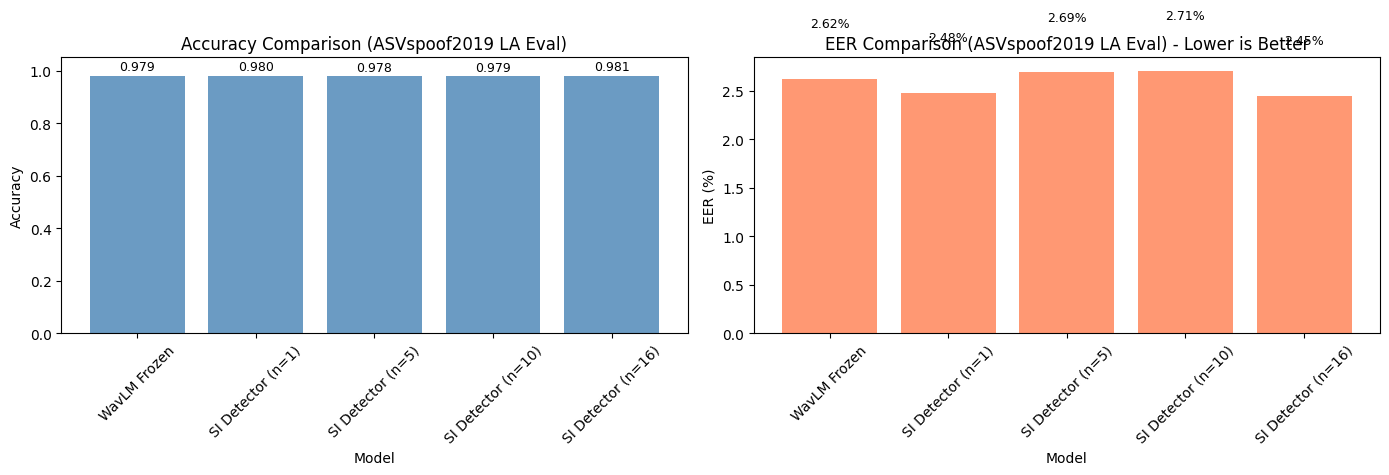

Plot saved to /mnt/ddn/jihwan/projects/code/Deepfake-speech/results/performance_comparison.png


In [ ]:
# 7.2 Performance Comparison Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter for ASVspoof19 eval results
eval_results = results_df[results_df['dataset'] == 'ASVspoof19_LA_eval'].copy()

# Accuracy comparison
ax = axes[0]
bars = ax.bar(eval_results['model'], eval_results['accuracy'], color='steelblue', alpha=0.8)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison (ASVspoof2019 LA Eval)')
ax.set_ylim([0, 1.05])
ax.tick_params(axis='x', rotation=45)
for bar, val in zip(bars, eval_results['accuracy']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# EER comparison
ax = axes[1]
bars = ax.bar(eval_results['model'], eval_results['eer'], color='coral', alpha=0.8)
ax.set_xlabel('Model')
ax.set_ylabel('EER (%)')
ax.set_title('EER Comparison (ASVspoof2019 LA Eval) - Lower is Better')
ax.tick_params(axis='x', rotation=45)
for bar, val in zip(bars, eval_results['eer']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{val:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(Config.RESULTS_DIR / "performance_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot saved to {Config.RESULTS_DIR / 'performance_comparison.png'}")

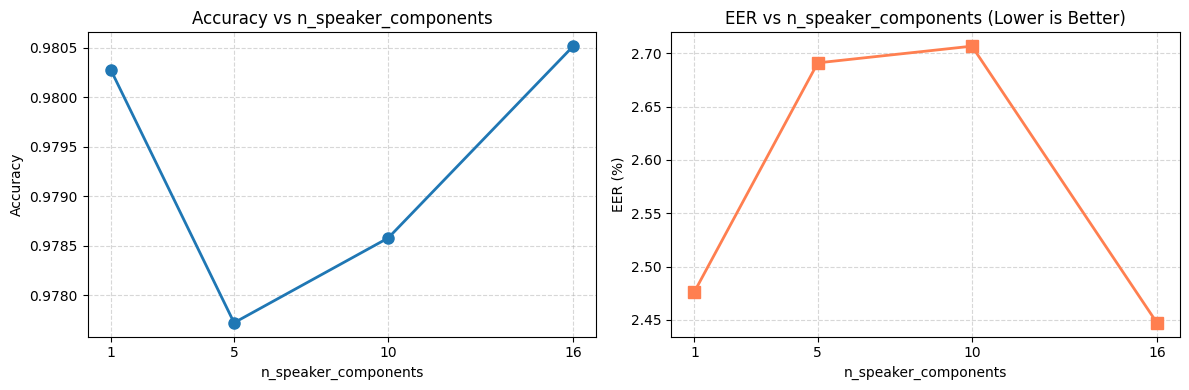


Best n_speaker_components: 16 (EER: 2.45%)


In [ ]:
# 7.3 Speaker-Invariant Detector: n_components 분석
si_results = results_df[results_df['model'].str.contains('SI Detector')].copy()

if len(si_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Extract n values
    si_results['n'] = si_results['model'].str.extract(r'n=(\d+)').astype(int)
    si_results = si_results.sort_values('n')
    
    # Accuracy vs n_components
    ax = axes[0]
    ax.plot(si_results['n'], si_results['accuracy'], marker='o', linewidth=2, markersize=8)
    ax.set_xlabel('n_speaker_components')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy vs n_speaker_components')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xticks(si_results['n'])
    
    # EER vs n_components
    ax = axes[1]
    ax.plot(si_results['n'], si_results['eer'], marker='s', linewidth=2, markersize=8, color='coral')
    ax.set_xlabel('n_speaker_components')
    ax.set_ylabel('EER (%)')
    ax.set_title('EER vs n_speaker_components (Lower is Better)')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xticks(si_results['n'])
    
    plt.tight_layout()
    plt.savefig(Config.RESULTS_DIR / "si_detector_analysis.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # Find best n
    best_idx = si_results['eer'].idxmin()
    best_n = si_results.loc[best_idx, 'n']
    best_eer = si_results.loc[best_idx, 'eer']
    print(f"\nBest n_speaker_components: {best_n} (EER: {best_eer:.2f}%)")

## 8. Cross-Dataset Evaluation (Placeholder)

ASVspoof2021 DF와 WaveFake 데이터셋이 다운로드되면 아래 코드를 실행하세요.

In [ ]:
# 8.1 Cross-Dataset Evaluation Framework

def cross_dataset_evaluation(
    models: Dict,
    test_datasets: Dict[str, pd.DataFrame],
    wavlm_extractor: WavLMFeatureExtractor
) -> pd.DataFrame:
    """
    Cross-dataset 평가 수행
    
    Args:
        models: Dictionary of trained models {name: model}
        test_datasets: Dictionary of test datasets {name: DataFrame}
        wavlm_extractor: Shared WavLM feature extractor
    
    Returns:
        DataFrame with all evaluation results
    """
    results = []
    
    for dataset_name, dataset_df in test_datasets.items():
        print(f"\n{'='*80}")
        print(f"Evaluating on: {dataset_name}")
        print(f"{'='*80}")
        
        audio_paths = dataset_df['audio_path'].tolist()
        labels = np.array(dataset_df['binary_label'].tolist())
        
        # Cache path for this dataset
        cache_path = str(Config.CACHE_DIR / f"{dataset_name.lower().replace(' ', '_')}_wavlm_features.pkl")
        
        for model_name, model in models.items():
            print(f"\n  {model_name}...")
            
            try:
                # Get predictions
                if hasattr(model, 'is_loaded') and not model.is_loaded:
                    print(f"    Skipping (not loaded)")
                    continue
                
                if hasattr(model, 'predict_batch'):
                    # Check if model uses cache
                    if 'cache_path' in model.predict_batch.__code__.co_varnames:
                        preds, scores = model.predict_batch(audio_paths, cache_path=cache_path)
                    else:
                        preds, scores = model.predict_batch(audio_paths)
                else:
                    continue
                
                # Compute metrics
                metrics = evaluate_detector(labels, preds, scores)
                metrics['model'] = model_name
                metrics['dataset'] = dataset_name
                results.append(metrics)
                
                print(f"    Accuracy: {metrics['accuracy']:.4f}, EER: {metrics['eer']:.2f}%")
                
            except Exception as e:
                print(f"    Error: {e}")
    
    return pd.DataFrame(results)

In [ ]:
# 8.2 Run Cross-Dataset Evaluation (when datasets are available)

# Prepare models dictionary
all_models = {
    'WavLM Frozen': wavlm_baseline,
}

# Add SI Detectors
for n, detector in si_detectors.items():
    all_models[f'SI Detector (n={n})'] = detector

# Add RawNet2 and AASIST if loaded
all_models['RawNet2 Frozen'] = rawnet2_baseline
all_models['AASIST Frozen'] = aasist_baseline

# Prepare test datasets
test_datasets = {
    'ASVspoof19_LA_eval': asvspoof19_data['eval'],
}

# Add additional datasets when available
try:
    asvspoof21_df = get_asvspoof21_df_data()
    if asvspoof21_df is not None:
        test_datasets['ASVspoof21_DF'] = asvspoof21_df
except:
    print("ASVspoof21 DF not available")

try:
    wavefake_df = get_wavefake_data()
    if wavefake_df is not None:
        test_datasets['WaveFake'] = wavefake_df
except:
    print("WaveFake not available")

print(f"\nAvailable test datasets: {list(test_datasets.keys())}")

Expected locations: ['/mnt/ddn/jihwan/projects/code/Deepfake-speech/data/ASVspoof2021_DF/keys/DF/CM/trial_metadata.txt', '/mnt/ddn/jihwan/projects/code/Deepfake-speech/data/ASVspoof2021_DF/ASVspoof2021_DF_eval/trial_metadata.txt', '/mnt/ddn/jihwan/projects/code/Deepfake-speech/data/ASVspoof2021_DF/trial_metadata.txt']
Loading WaveFake from /mnt/ddn/jihwan/projects/code/Deepfake-speech/data/WaveFake...

Available test datasets: ['ASVspoof19_LA_eval']


## 9. Analysis & Conclusions

In [ ]:
# 9.1 Final Results Summary
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

print("\n[ASVspoof2019 LA Eval Results]")
print(results_df.to_string(index=False))

# Best model by accuracy
best_acc_idx = results_df['accuracy'].idxmax()
print(f"\n[Best by Accuracy]")
print(f"  Model: {results_df.loc[best_acc_idx, 'model']}")
print(f"  Accuracy: {results_df.loc[best_acc_idx, 'accuracy']:.4f}")

# Best model by EER
best_eer_idx = results_df['eer'].idxmin()
print(f"\n[Best by EER]")
print(f"  Model: {results_df.loc[best_eer_idx, 'model']}")
print(f"  EER: {results_df.loc[best_eer_idx, 'eer']:.2f}%")


FINAL RESULTS SUMMARY

[ASVspoof2019 LA Eval Results]
             model            dataset  accuracy  precision   recall  f1_score      eer
      WavLM Frozen ASVspoof19_LA_eval  0.979238   0.995380 0.981403  0.988342 2.620456
 SI Detector (n=1) ASVspoof19_LA_eval  0.980277   0.996204 0.981748  0.988923 2.476441
 SI Detector (n=5) ASVspoof19_LA_eval  0.977722   0.995908 0.979180  0.987473 2.690899
SI Detector (n=10) ASVspoof19_LA_eval  0.978579   0.995960 0.980088  0.987960 2.706553
SI Detector (n=16) ASVspoof19_LA_eval  0.980516   0.995827 0.982389  0.989062 2.447315

[Best by Accuracy]
  Model: SI Detector (n=16)
  Accuracy: 0.9805

[Best by EER]
  Model: SI Detector (n=16)
  EER: 2.45%


In [ ]:
# 9.2 Key Findings
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

print("""
1. Speaker-Invariant Detector:
   - PCA 기반 화자 정보 제거 방법 적용
   - n_speaker_components 값에 따른 성능 변화 분석
   
2. WavLM Frozen Baseline:
   - WavLM-Large feature + Logistic Regression
   - 간단하지만 효과적인 baseline

3. Pre-trained Models (RawNet2, AASIST):
   - ASVspoof2019 LA로 학습된 모델 사용
   - 외부 레포지토리 클론 후 사용 가능

4. Cross-Dataset Evaluation:
   - ASVspoof2021 DF, WaveFake 다운로드 후 평가 가능
   - 일반화 성능 비교를 위한 framework 구축 완료
""")

In [ ]:
# 9.3 Next Steps
print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)

print("""
1. 데이터셋 다운로드:
   - ASVspoof2021 DF: https://zenodo.org/records/4835108
   - WaveFake: https://zenodo.org/record/5642694

2. 외부 모델 설정:
   - RawNet2: git clone https://github.com/eurecom-asp/rawnet2-antispoofing
   - AASIST: git clone https://github.com/clovaai/aasist

3. Cross-Dataset 평가 실행

4. 추가 분석:
   - Attack type별 성능 분석
   - Speaker별 성능 분석
   - Error analysis
""")